In [1]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers

from collections import defaultdict #, Counter
from transformers import AutoModelForMaskedLM, AutoTokenizer

from operator import mul
from functools import reduce


device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

MODEL_NAME = 'bert-base-multilingual-uncased'
MASK_TOKEN = '[MASK]'
PAD_TOKEN = '[PAD]'
BOS_TOKEN = '[CLS]'
EOS_TOKEN = '[SEP]'

KWORDS_THING = ('quoi que ce soit','quoi que ce soit','quoi que ce soit','quoi que ce soit')
KWORDS_BODY  = ('qui que ce soit','qui que ce soit','qui que ce soit','qui que ce soit')
INPUT_FILE = 'fr_test_sentences_newwords.tsv'

PREFIX = 'fr_mbert'

BATCH_SIZE = 40 
assert BATCH_SIZE%4 == 0, '# important to have BATCH_SIZE%4 == 0'

RANDOM_TOKENS = 40

keywords = list(set(KWORDS_THING)|set(KWORDS_BODY))


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(['[NOT]','[FEW]','[MANY]'], special_tokens=True)

model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))

device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
# let's check the number of tokens in our keywords

torch.manual_seed(0)
np.random.seed(0)

keywords2tokens = dict()

for keyword in keywords:
    tokens = tokenizer.tokenize(keyword)
    keywords2tokens[keyword] = tokens
#     keywords2random_tokens[keyword] = np.random.choice(range(max(reverse_vocab)), (TEST_CASES_PER_SIZE,len(tokens)))
    print(len(tokens), tokens)

random_tokens = dict()
for tok in ('[NOT]', '[FEW]', '[MANY]'):
    random_tokens[tok] = np.random.choice(range(max(reverse_vocab)), RANDOM_TOKENS)

4 ['qui', 'que', 'ce', 'soit']
4 ['quoi', 'que', 'ce', 'soit']


In [3]:
from glob import glob

mapping = {
    'few' : '[FEW]',
    'not' : '[NOT]',
    'many' : '[MANY]',
}

random_tokens = {'[FEW]':[], '[NOT]':[], '[MANY]':[]}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(['[NOT]','[FEW]','[MANY]'], special_tokens=True)

for idx, fn in enumerate(glob('embeds/mbert/embd.*.txt')):
    chunks = fn.split('.')
    v = np.loadtxt(fn)
    tok = f'{mapping[chunks[1]]}_{idx%40:02}'
    tokenizer.add_tokens(tok, special_tokens=True)
    random_tokens[mapping[chunks[1]]].append( tokenizer.vocab[tok] )

model.resize_token_embeddings(len(tokenizer))

for idx, fn in enumerate(glob('embeds/mbert/embd.*.txt')):
    chunks = fn.split('.')
    v = np.loadtxt(fn)
    tok = f'{mapping[chunks[1]]}_{idx%40:02}'
    print(chunks[1], tok, tokenizer.vocab[tok])
    model.bert.embeddings.word_embeddings.weight.data[[tokenizer.vocab[tok]]] = torch.Tensor(v).cuda()


few [FEW]_00 105882
few [FEW]_01 105883
few [FEW]_02 105884
few [FEW]_03 105885
few [FEW]_04 105886
few [FEW]_05 105887
few [FEW]_06 105888
few [FEW]_07 105889
few [FEW]_08 105890
few [FEW]_09 105891
few [FEW]_10 105892
few [FEW]_11 105893
few [FEW]_12 105894
few [FEW]_13 105895
few [FEW]_14 105896
few [FEW]_15 105897
few [FEW]_16 105898
few [FEW]_17 105899
few [FEW]_18 105900
few [FEW]_19 105901
few [FEW]_20 105902
few [FEW]_21 105903
few [FEW]_22 105904
few [FEW]_23 105905
few [FEW]_24 105906
few [FEW]_25 105907
few [FEW]_26 105908
few [FEW]_27 105909
few [FEW]_28 105910
few [FEW]_29 105911
few [FEW]_30 105912
few [FEW]_31 105913
few [FEW]_32 105914
few [FEW]_33 105915
few [FEW]_34 105916
few [FEW]_35 105917
few [FEW]_36 105918
few [FEW]_37 105919
few [FEW]_38 105920
few [FEW]_39 105921
many [MANY]_00 105922
many [MANY]_01 105923
many [MANY]_02 105924
many [MANY]_03 105925
many [MANY]_04 105926
many [MANY]_05 105927
many [MANY]_06 105928
many [MANY]_07 105929
many [MANY]_08 105930
ma

In [4]:
print(random_tokens['[NOT]'])
print(model.bert.embeddings.word_embeddings.weight.data[random_tokens['[NOT]'][-2]])

[105962, 105963, 105964, 105965, 105966, 105967, 105968, 105969, 105970, 105971, 105972, 105973, 105974, 105975, 105976, 105977, 105978, 105979, 105980, 105981, 105982, 105983, 105984, 105985, 105986, 105987, 105988, 105989, 105990, 105991, 105992, 105993, 105994, 105995, 105996, 105997, 105998, 105999, 106000, 106001]
tensor([-2.4975e-03, -4.0306e-03, -1.9321e-02, -3.0008e-02, -2.6400e-02,
        -7.2324e-03, -1.0818e-02,  5.9858e-03,  1.4394e-02,  1.1939e-02,
         6.2217e-03,  1.6067e-02, -1.9615e-02, -5.7582e-03, -2.1200e-02,
         1.2174e-02,  2.7995e-03,  1.8247e-02, -1.2414e-02,  1.6018e-02,
         1.2374e-02,  1.5210e-03, -1.7384e-02,  1.1739e-02,  2.7829e-02,
        -2.0552e-02, -2.5161e-02, -1.3190e-03,  1.7439e-02,  2.5955e-02,
        -2.6755e-02, -6.3985e-03,  7.9212e-03,  2.9368e-03, -1.0185e-02,
        -4.6820e-03, -3.3066e-02,  6.4388e-04,  1.0439e-02, -2.4901e-02,
         4.3381e-02, -1.6821e-02,  3.5435e-02,  8.2338e-03,  1.2869e-02,
        -1.7724e-02, -

In [5]:
!type embd.not.mbert.38.txt

-2.497513778507709503e-03 -4.030620213598012924e-03 -1.932137459516525269e-02 -3.000780381262302399e-02 -2.639990858733654022e-02 -7.232447620481252670e-03 -1.081782300025224686e-02 5.985805299133062363e-03 1.439423486590385437e-02 1.193942222744226456e-02 6.221672985702753067e-03 1.606678403913974762e-02 -1.961517706513404846e-02 -5.758211482316255569e-03 -2.119988575577735901e-02 1.217376720160245895e-02 2.799452980980277061e-03 1.824690774083137512e-02 -1.241382304579019547e-02 1.601807214319705963e-02 1.237366534769535065e-02 1.520979567430913448e-03 -1.738423481583595276e-02 1.173863466829061508e-02 2.782862633466720581e-02 -2.055196091532707214e-02 -2.516071870923042297e-02 -1.318976166658103466e-03 1.743896491825580597e-02 2.595530450344085693e-02 -2.675499208271503448e-02 -6.398465950042009354e-03 7.921175099909305573e-03 2.936764620244503021e-03 -1.018537301570177078e-02 -4.682045429944992065e-03 -3.306629508733749390e-02 6.438813870772719383e-04 1.043885946273803711e-02 -2.49

In [6]:
list(sorted(filter(lambda x:x[0]=='[',tokenizer.vocab.keys())))[-250:]

['[',
 '[CLS]',
 '[FEW]',
 '[FEW]_00',
 '[FEW]_01',
 '[FEW]_02',
 '[FEW]_03',
 '[FEW]_04',
 '[FEW]_05',
 '[FEW]_06',
 '[FEW]_07',
 '[FEW]_08',
 '[FEW]_09',
 '[FEW]_10',
 '[FEW]_11',
 '[FEW]_12',
 '[FEW]_13',
 '[FEW]_14',
 '[FEW]_15',
 '[FEW]_16',
 '[FEW]_17',
 '[FEW]_18',
 '[FEW]_19',
 '[FEW]_20',
 '[FEW]_21',
 '[FEW]_22',
 '[FEW]_23',
 '[FEW]_24',
 '[FEW]_25',
 '[FEW]_26',
 '[FEW]_27',
 '[FEW]_28',
 '[FEW]_29',
 '[FEW]_30',
 '[FEW]_31',
 '[FEW]_32',
 '[FEW]_33',
 '[FEW]_34',
 '[FEW]_35',
 '[FEW]_36',
 '[FEW]_37',
 '[FEW]_38',
 '[FEW]_39',
 '[MANY]',
 '[MANY]_00',
 '[MANY]_01',
 '[MANY]_02',
 '[MANY]_03',
 '[MANY]_04',
 '[MANY]_05',
 '[MANY]_06',
 '[MANY]_07',
 '[MANY]_08',
 '[MANY]_09',
 '[MANY]_10',
 '[MANY]_11',
 '[MANY]_12',
 '[MANY]_13',
 '[MANY]_14',
 '[MANY]_15',
 '[MANY]_16',
 '[MANY]_17',
 '[MANY]_18',
 '[MANY]_19',
 '[MANY]_20',
 '[MANY]_21',
 '[MANY]_22',
 '[MANY]_23',
 '[MANY]_24',
 '[MANY]_25',
 '[MANY]_26',
 '[MANY]_27',
 '[MANY]_28',
 '[MANY]_29',
 '[MANY]_30',
 '[MANY]_

In [7]:
# parse, mask, tokenize

subj_dict = dict()
verb_dict = dict()

def mask_sent(sent, kword):
    return [BOS_TOKEN,] + tokenizer.tokenize( 
        sent.replace(kword, f'{MASK_TOKEN} '*len(keywords2tokens[kword])).replace('  ',' ') 
    ) + [EOS_TOKEN,]

tokenized_array = []
metadata_array = []

lines = [line for idx, line in enumerate(open(INPUT_FILE, encoding='utf-8'))]

np.random.seed(0)
np.random.shuffle(lines)

for idx, line in enumerate(lines):
    chunks = line.strip().split()
    tchunks = line.strip().split('\t')

    if chunks[-1]=='thing':
        kwords = KWORDS_THING
    else:
        kwords = KWORDS_BODY
    
    subj_id = int(chunks[-3])
    subject = chunks[1]
    subj_dict[subj_id] = subject
    verb_id = int(chunks[-2])
    verb1 = chunks[2]
    verb2 = chunks[8]
    verb_dict[verb_id] = (verb1, verb2)
    
    for tidx, (cl,kword) in enumerate( zip( ('aff', 'neg', 'many', 'few'), kwords ) ):
        mt_sent = mask_sent(tchunks[tidx], kword)
        tokenized_array.append( mt_sent )
        metadata_array.append( 
            (
                (cl, subj_id, verb_id, kword, chunks[-1]),
                (tchunks[tidx], mt_sent)
            )
        )


In [9]:
def assess_batch(batch, metas, r_idx):
    global scores
    batch_input_ids = []
    batch_segment_ids = []
    
    mask_positions = []
    mask_lens = []

    max_len = max(map(len,batch))
    
    for idx, s in enumerate(batch):
        mask_positions.append( s.index(MASK_TOKEN) )
        mask_lens.append( s.count(MASK_TOKEN) )
        
        input_ids = tokenizer.convert_tokens_to_ids(s + [PAD_TOKEN,]*(max_len-len(s)))
        for tok in ('[NOT]', '[FEW]', '[MANY]'): # replace spec tokens with random ones
            if tok in s:
#                 print(tok,r_idx)
                input_ids[s.index(tok)] = random_tokens[tok][r_idx]

        batch_input_ids.append( input_ids )
        batch_segment_ids.append( [0] * len(input_ids) )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    return [
        reduce(mul, [pr[pos+t_pos][tokenizer.vocab[tok]].cpu().detach().numpy() \
            for t_pos, tok in enumerate(keywords2tokens[meta[0][3]]) ], 1. ) \
                for pr, pos, meta in zip(probs, mask_positions, metas)
    ]
        
assess_batch(tokenized_array[128*4:130*4], metadata_array[126*4:130*4], 1)

[5.646793904412495e-16,
 2.795109908228201e-15,
 3.85481225760639e-15,
 3.66639826228655e-15,
 9.677631053218455e-17,
 4.4123919425877845e-16,
 1.6181486741704846e-14,
 7.445336349620778e-15]

In [10]:
# assess all the sentences

scores = defaultdict(list)
for b_idx, idx in enumerate(range(0, len(tokenized_array), BATCH_SIZE)):
    if not idx%200: print(f'{idx/(len(tokenized_array)):.2%}')
    scores[b_idx%RANDOM_TOKENS].extend( assess_batch(tokenized_array[idx:idx+BATCH_SIZE], 
                                                     metadata_array[idx:idx+BATCH_SIZE], 
                                                     b_idx%RANDOM_TOKENS) ) # here we select the set of random tokens

0.00%
0.50%
1.00%
1.50%
2.00%
2.50%
3.00%
3.50%
4.00%
4.50%
5.00%
5.50%
6.00%
6.50%
7.00%
7.50%
8.00%
8.50%
9.00%
9.50%
10.00%
10.50%
11.00%
11.50%
12.00%
12.50%
13.00%
13.50%
14.00%
14.50%
15.00%
15.50%
16.00%
16.50%
17.00%
17.50%
18.00%
18.50%
19.00%
19.50%
20.00%
20.50%
21.00%
21.50%
22.00%
22.50%
23.00%
23.50%
24.00%
24.50%
25.00%
25.50%
26.00%
26.50%
27.00%
27.50%
28.00%
28.50%
29.00%
29.50%
30.00%
30.50%
31.00%
31.50%
32.00%
32.50%
33.00%
33.50%
34.00%
34.50%
35.00%
35.50%
36.00%
36.50%
37.00%
37.50%
38.00%
38.50%
39.00%
39.50%
40.00%
40.50%
41.00%
41.50%
42.00%
42.50%
43.00%
43.50%
44.00%
44.50%
45.00%
45.50%
46.00%
46.50%
47.00%
47.50%
48.00%
48.50%
49.00%
49.50%
50.00%
50.50%
51.00%
51.50%
52.00%
52.50%
53.00%
53.50%
54.00%
54.50%
55.00%
55.50%
56.00%
56.50%
57.00%
57.50%
58.00%
58.50%
59.00%
59.50%
60.00%
60.50%
61.00%
61.50%
62.00%
62.50%
63.00%
63.50%
64.00%
64.50%
65.00%
65.50%
66.00%
66.50%
67.00%
67.50%
68.00%
68.50%
69.00%
69.50%
70.00%
70.50%
71.00%
71.50%
72.00%
72.50

In [11]:
np.array(scores).shape
len(scores)
len(scores[39])

# shape of score is [random_tokens_idx][ (aff_prob, neg_prob, many_prob, few_prob)*items ]

1000

In [12]:
stats = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))

for r_idx in range(RANDOM_TOKENS):
    for score, meta in zip(scores[r_idx], metadata_array):
        if meta[0][0]=='aff':
            handle = (meta[0][4], 'aff>neg')
            k_idx = 0
        if meta[0][0]=='neg':
            handle = (meta[0][4], 'aff>neg')
            k_idx = 1
        if meta[0][0]=='many':
            handle = (meta[0][4], 'many>few')
            k_idx = 0
        if meta[0][0]=='few':
            handle = (meta[0][4], 'many>few')
            k_idx = 1
        handle2 = ('both', handle[1])
        stats[handle][r_idx][k_idx].append( score )
        stats[handle2][r_idx][k_idx].append( score )

# shape of stats now is
#  [handles][random_tokens_idx][(0 for aff and many, 1 for neg and few)][items]
# where handle is one of ('body', 'aff>neg'), ('body', 'many>few'), ('both', 'aff>neg'), 
#                          ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')

In [13]:
measures = dict()
for handle in sorted(stats):
    r = []
    for r_idx in range(RANDOM_TOKENS):
        r.append( np.count_nonzero(list(map(lambda x:x[0]>x[1], zip(stats[handle][r_idx][0],stats[handle][r_idx][1]))))/len(stats[handle][r_idx][0]) )
    print(handle, f'  mean {np.mean(r):0.3%} std {np.std(r):0.3%}')
    measures[handle] = r[:]
    
# shape of measures is 
#   [handles][ random_tokens_idx scores ]

('both', 'aff>neg')   mean 31.470% std 17.142%
('both', 'many>few')   mean 63.910% std 17.113%
('thing', 'aff>neg')   mean 31.470% std 17.142%
('thing', 'many>few')   mean 63.910% std 17.113%


dict_keys([('both', 'aff>neg'), ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')])

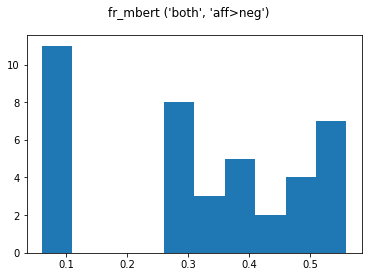

In [22]:
# r
plt.hist(measures[('both', 'aff>neg')])
plt.suptitle(f'{PREFIX} '+str(('both', 'aff>neg')))
measures.keys()

dict_keys([('both', 'aff>neg'), ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')])

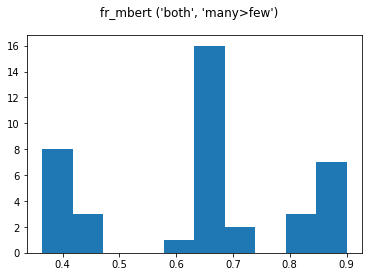

In [23]:
# r
plt.hist(measures[('both', 'many>few')])
plt.suptitle(f'{PREFIX} '+str(('both', 'many>few')))
measures.keys()

In [16]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import dill

with open(f'{PREFIX}_trained_scores.pkl', 'wb') as f:
    pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)
with open(f'{PREFIX}_trained_stats.pkl', 'wb') as f:
    dill.dump(stats, f)
with open(f'{PREFIX}_trained_measures.pkl', 'wb') as f:
    pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        

In [24]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import dill

with open(f'{PREFIX}_baseline_measures.pkl', 'rb') as f:
#     pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        
    a = pickle.load(f)
with open(f'{PREFIX}_trained_measures.pkl', 'rb') as f:
#     pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        
    b = pickle.load(f)
    

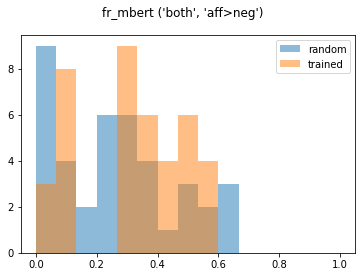

In [25]:
import matplotlib.pyplot as plt

plt.hist(a[('both', 'aff>neg')], range=(0,1), label='random', alpha=.5, bins=15)
plt.hist(b[('both', 'aff>neg')], range=(0,1), label='trained', alpha=.5, bins=15)
plt.suptitle(f'{PREFIX} '+str(('both', 'aff>neg')))
plt.legend()


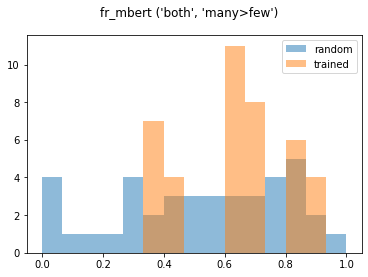

In [26]:
import matplotlib.pyplot as plt

plt.hist(a[('both', 'many>few')], range=(0,1), label='random', alpha=.5, bins=15)
plt.hist(b[('both', 'many>few')], range=(0,1), label='trained', alpha=.5, bins=15)
plt.suptitle(f'{PREFIX} '+str(('both', 'many>few')))
plt.legend()


In [27]:
import math
from scipy.stats import norm, invgamma,mannwhitneyu,ttest_ind
from scipy import stats
from scipy.optimize import curve_fit


def stat_tests(sample1,sample2):
	result = []
	if len(sample1)==0 or math.isnan(float(list(set(sample1))[0])):
		tt = "nan"
		mw = "nan"
	else:
		try:
			# mw = mannwhitneyu(sample1,sample2,alternative='two-sided')[1]
			mw = mannwhitneyu(sample1,sample2)[1]*2.
			# print sample1
			# print "<br><br>"
			# print list(set(sample1))[0],"<br>"
		except:
			mw = "nan"
		tt = ttest_ind(sample1,sample2)[1]
	# print m,gp,mw,tt
	# result.append(gp)
	result.append(mw)
	result.append(tt)
	return result


In [28]:
z = stat_tests(a[('both', 'aff>neg')], b[('both', 'aff>neg')])
print(z)
print(f'{z[0]:0.03%} {z[1]:0.03%}')

[0.0997959292653287, 0.1924908296353282]
9.980% 19.249%


In [29]:
z = stat_tests(a[('both', 'many>few')], b[('both', 'many>few')])
print(z)
print(f'{z[0]:0.03%} {z[1]:0.03%}')

[0.1038557555623791, 0.03216198786923033]
10.386% 3.216%
